In [1]:
import pandas as pd
import numpy as np
import string
import nltk
import matplotlib.pyplot as plt
import warnings
from nltk import word_tokenize, pos_tag, FreqDist, SnowballStemmer
from nltk.corpus import wordnet as wn, stopwords
from gensim import corpora, models
from operator import itemgetter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import pipeline
from wordcloud import WordCloud
from nltk.util import ngrams

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

C:\Users\Michael\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
userComments1 = pd.read_csv('C:/Users/Michael/Documents/GitHub/EBAC/dataSources/videoGames/metacritic_game_user_comments (0-100k).csv')
userComments2 = pd.read_csv('C:/Users/Michael/Documents/GitHub/EBAC/dataSources/videoGames/metacritic_game_user_comments (100-200k).csv')
userComments3 = pd.read_csv('C:/Users/Michael/Documents/GitHub/EBAC/dataSources/videoGames/metacritic_game_user_comments (200-300k).csv')

userComments3['Unnamed: 0'] = userComments3['Unnamed: 0'].astype('float64')
userComments3['Userscore'] = userComments3['Userscore'].astype('float64')

userComments = pd.concat([userComments1, userComments2, userComments3], axis = 0)
userComments.drop(columns = 'Unnamed: 0', inplace = True)
userComments.dropna(how = 'all', inplace = True)

userComments.Platform.unique()

platformMap = {
'Nintendo64': 'Nintendo',
'GameBoyAdvance': 'Nintendo',
'3DS': 'Nintendo',
'DS': 'Nintendo',
'Wii': 'Nintendo',
'Switch': 'Nintendo',
'WiiU': 'Nintendo',
'GameCube': 'Nintendo',
'PlayStation': 'PlayStation',
'PlayStation3': 'PlayStation',
'PlayStation2': 'PlayStation',
'PlayStation4': 'PlayStation',
'PlayStationVita': 'PlayStation',
'PSP': 'PlayStation',
'Xbox360': 'Xbox',
'Xbox': 'Xbox',
'XboxOne': 'Xbox',
'PC': 'PC',
'Dreamcast': 'Others',
'not specified': 'Others'
}

userComments['platformCondensed'] = userComments.Platform.map(platformMap)

In [60]:
filter_list = ["would", "could", "left", "right", "a.m.", "p.m.", "'s", "! ! !", "...", ":", ";", "n't", "game", "games", "play", "fun", "much", "one", "great", "time"]

def preprocess_text(tokens, needtokenizeBoolean = True, grams = False,  ngramsNummber = 2, furtherPreProcessNgrams = False):
    
    if needtokenizeBoolean:
        tokens = nltk.word_tokenize(tokens)
        if grams:
            tokens = list(ngrams(tokens, ngramsNummber))
    if grams:
        tokens = [' '.join(gram) for gram in tokens]
        if furtherPreProcessNgrams == False:
            return tokens
            
    tokens = [t.lower() for t in tokens]
    tokens = [t for t in tokens if t not in stopwords.words('english') + filter_list]
    tokens = [t for t in tokens if t not in string.punctuation]
    tokens = [t for t in tokens if not t.isnumeric()]
    snowball = SnowballStemmer('english')
    tokens = [snowball.stem(t) for t in tokens]
    
    return tokens

def wc(df, columnName, preProcessingFunctionBoolean = True, tfidfVectorizerBoolean = True, vectorizerMinDf = 2, vectorizerMaxDf = 0.7, countVectorizerBinary = True,
       nounTaggingBoolean = False, universalNounTagsetBoolean = False, ngrams = False, ngramsNummber = 2, furtherPreProcessNgrams = False,
       top = 10, features_improvements = 'Word Cloud', platform = 'All'):

    if preProcessingFunctionBoolean == True & ngrams == True:
        if tfidfVectorizerBoolean == True:
            if furtherPreProcessNgrams == True:
                tdm = TfidfVectorizer(tokenizer=lambda text: preprocess_text(text, grams=True, ngramsNummber=ngramsNummber, furtherPreProcessNgrams = True), min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
            else:
                tdm = TfidfVectorizer(tokenizer=lambda text: preprocess_text(text, grams=True, ngramsNummber=ngramsNummber), min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
        else:
            if furtherPreProcessNgrams == True:
                tdm = CountVectorizer(binary = countVectorizerBinary, tokenizer=lambda text: preprocess_text(text, grams=True, ngramsNummber=ngramsNummber, furtherPreProcessNgrams = True), min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
            else:
                tdm = CountVectorizer(binary = countVectorizerBinary, tokenizer=lambda text: preprocess_text(text, grams=True, ngramsNummber=ngramsNummber), min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
        tdmMatrix = tdm.fit_transform(df[columnName])
    
    if nounTaggingBoolean == True and ngrams == False:
        noun_list = []
        for value in df[columnName]:
            if universalNounTagsetBoolean == True:
                tagged_value = pos_tag(word_tokenize(value), tagset='universal')
                noun = [word for word, tag in tagged_value if tag == 'NOUN']
            else:
                tagged_value = pos_tag(word_tokenize(value))
                noun = [word for word, tag in tagged_value if tag == 'NN' or tag == 'NNS']
            noun_list.append(noun)
        df['Text_NounOnly'] = noun_list
        if preProcessingFunctionBoolean == True:
            df['Text_NounOnly'] = df['Text_NounOnly'].apply(lambda x: preprocess_text(tokens = x, needtokenizeBoolean=False))
            df['Text_NounOnly'] = df['Text_NounOnly'].apply(lambda x: ', '.join(x))
        else:
            df['Text_NounOnly'] = df['Text_NounOnly'].apply(lambda x: ', '.join(x))
        if tfidfVectorizerBoolean == True:
            tdm = TfidfVectorizer(min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
        else:
            tdm = CountVectorizer(binary = countVectorizerBinary, min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
        tdmMatrix = tdm.fit_transform(df['Text_NounOnly'])
        
    if nounTaggingBoolean != True and ngrams == False:
        if tfidfVectorizerBoolean == True:
            if preProcessingFunctionBoolean == True:
                tdm = TfidfVectorizer(tokenizer = preprocess_text, min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
            else:
                tdm = TfidfVectorizer(min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
        else:
            if preProcessingFunctionBoolean == True:
                tdm = CountVectorizer(binary = countVectorizerBinary, tokenizer = preprocess_text, min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
            else:
                tdm = CountVectorizer(binary = countVectorizerBinary, min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
        tdmMatrix = tdm.fit_transform(df[columnName])

    array = tdmMatrix.toarray()
    feature_names = tdm.get_feature_names_out()
    word_tfidf = dict(zip(feature_names, array.sum(axis=0)))
    fd_tfidf= FreqDist(word_tfidf)
    wc = WordCloud(background_color="white").generate_from_frequencies(fd_tfidf)
    plt.figure()
    plt.suptitle(f"{features_improvements} ({platform})", fontsize = 20, x = 0.5, y = 0.85, fontweight = 'bold', fontname = 'Calibri') 
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    displayList = []
    for x,y in fd_tfidf.most_common(top):
        displayList.append((x, round(y, 2)))

    plt.show()
    print(displayList)

In [4]:
userComments.shape

(283983, 6)

In [50]:
# TO REMOVE THIS CELL AND RENAME BELOW CELLS EVENTUALLY!!
userCommentsTEST = userComments.sample(10000).copy()

In [51]:
userCommentsTESTNotNull = userCommentsTEST[userCommentsTEST.Comment.notnull()]

userCommentsTESTNotNull.loc[userCommentsTESTNotNull.Userscore > 7, 'scoreBin'] = 'High'
userCommentsTESTNotNull.loc[(userCommentsTESTNotNull.Userscore >= 4) & (userCommentsTESTNotNull.Userscore <= 7), 'scoreBin'] = 'Medium'
userCommentsTESTNotNull.loc[userCommentsTESTNotNull.Userscore < 4, 'scoreBin'] = 'Low'

userCommentsTESTHigh = userCommentsTESTNotNull[userCommentsTESTNotNull.scoreBin == 'High']
userCommentsTESTLow = userCommentsTESTNotNull[userCommentsTESTNotNull.scoreBin == 'Low']

userCommentsTESTExtreme_list = [userCommentsTESTHigh, userCommentsTESTLow]

In [52]:
platformCondensed_list = list(userCommentsTESTNotNull[userCommentsTESTNotNull.scoreBin != 'Medium'].platformCondensed.unique())
userCommentsTESTExtreme_list = [userCommentsTESTHigh, userCommentsTESTLow]

for platform in platformCondensed_list:
    for df in userCommentsTESTExtreme_list:
        print(f"{platform}, {df.reset_index().scoreBin[0]} Userscore; No. of comments: {df[df.Platform == platform].shape[0]}")

Xbox, High Userscore; No. of comments: 124
Xbox, Low Userscore; No. of comments: 7
Nintendo, High Userscore; No. of comments: 0
Nintendo, Low Userscore; No. of comments: 0
PC, High Userscore; No. of comments: 2617
PC, Low Userscore; No. of comments: 791
PlayStation, High Userscore; No. of comments: 68
PlayStation, Low Userscore; No. of comments: 1
Others, High Userscore; No. of comments: 0
Others, Low Userscore; No. of comments: 0


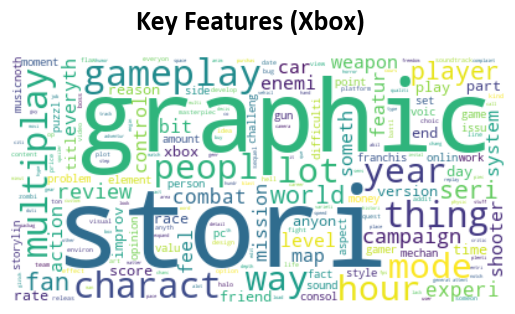

[('stori', 51.94), ('graphic', 40.5), ('gameplay', 33.56), ('charact', 30.5), ('thing', 30.08), ('multiplay', 29.46), ('year', 28.08), ('hour', 27.69), ('peopl', 27.65), ('way', 27.58)]


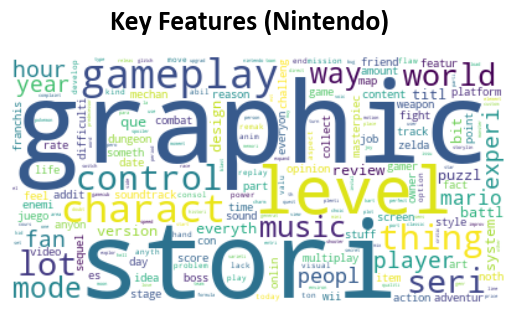

[('graphic', 34.76), ('stori', 30.7), ('level', 29.16), ('gameplay', 26.63), ('charact', 24.72), ('control', 23.43), ('thing', 23.22), ('seri', 21.69), ('lot', 21.46), ('world', 20.53)]


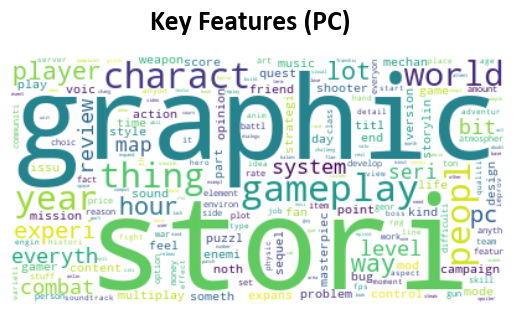

[('stori', 96.16), ('graphic', 88.61), ('gameplay', 71.55), ('charact', 66.44), ('year', 60.4), ('thing', 58.51), ('peopl', 57.89), ('world', 55.94), ('player', 54.82), ('hour', 54.68)]


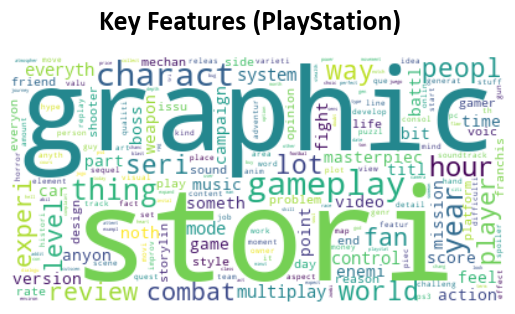

[('stori', 98.42), ('graphic', 76.04), ('gameplay', 64.41), ('charact', 64.38), ('thing', 46.86), ('year', 46.76), ('hour', 44.72), ('seri', 41.53), ('world', 41.32), ('lot', 40.98)]


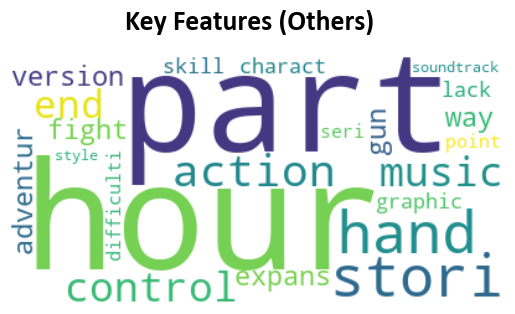

[('hour', 1.82), ('part', 1.76), ('stori', 1.45), ('hand', 1.44), ('action', 1.36), ('music', 1.15), ('control', 1.12), ('end', 1.0), ('version', 0.97), ('way', 0.96)]


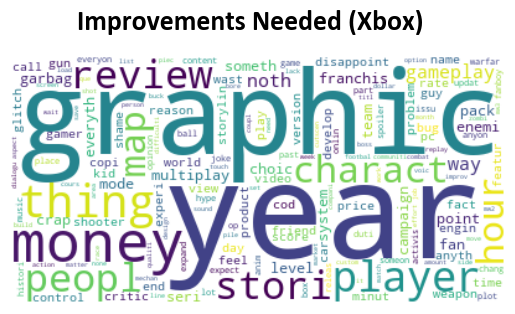

[('year', 12.32), ('graphic', 11.75), ('money', 11.38), ('thing', 11.12), ('player', 9.59), ('peopl', 9.08), ('review', 8.99), ('stori', 8.77), ('charact', 8.63), ('map', 8.54)]


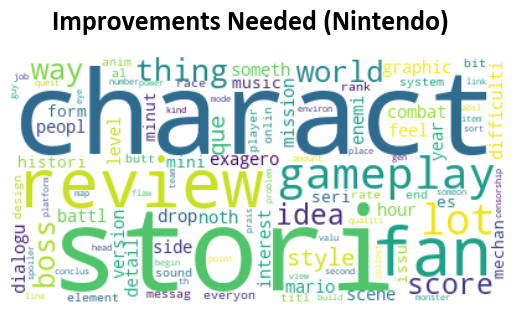

[('stori', 3.01), ('charact', 3.0), ('review', 2.46), ('fan', 2.41), ('gameplay', 1.89), ('lot', 1.69), ('thing', 1.65), ('world', 1.54), ('way', 1.5), ('score', 1.4)]


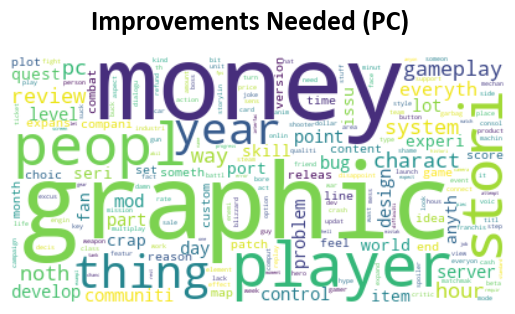

[('graphic', 21.37), ('money', 21.33), ('player', 20.06), ('peopl', 18.82), ('stori', 18.7), ('thing', 18.02), ('year', 16.89), ('gameplay', 16.2), ('noth', 16.07), ('way', 15.88)]


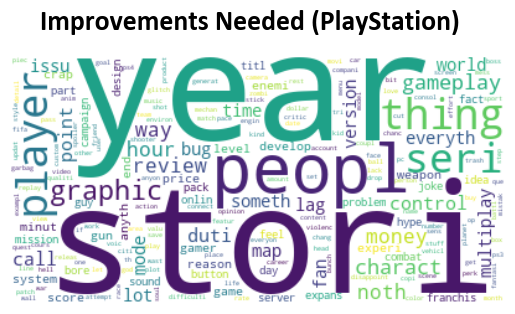

[('year', 12.92), ('stori', 12.51), ('peopl', 11.7), ('thing', 10.37), ('player', 10.17), ('seri', 9.71), ('graphic', 9.6), ('gameplay', 9.4), ('charact', 9.34), ('money', 8.79)]


ValueError: empty vocabulary; perhaps the documents only contain stop words

In [58]:
%%time

# Can adjust the parameters in this function to fine tune and iterate testings. Can adjust score bins, sample size and filter list above too!
# If ngrams = True, preProcessingFunctionBoolean needs to be True
# ValueError: max_df corresponds to < documents than min_df; ValueError: empty vocabulary - perhaps the documents only contain stop words .. If get these errors, it may simply be because of small sample size

for df in userCommentsTESTExtreme_list:
    for platform in platformCondensed_list:
            if df.scoreBin.max() == 'High':
                features_improvements = 'Key Features'
            elif df.scoreBin.max() == 'Low':
                features_improvements = 'Improvements Needed'
            wc(df = df[df.platformCondensed == platform], columnName = 'Comment',
               preProcessingFunctionBoolean = True, vectorizerMinDf = 2, vectorizerMaxDf = 0.7,
               countVectorizerBinary = True, tfidfVectorizerBoolean = True,
               ngrams = False, ngramsNummber = 3, furtherPreProcessNgrams = True,
               nounTaggingBoolean = True, universalNounTagsetBoolean = False,
               top = 10, features_improvements = features_improvements, platform = platform)